## Imports

In [1]:
# Python imports
import os
import sys
import json
from pathlib import Path
import gc
import inspect
from copy import deepcopy
from copy import copy
from datetime import datetime

import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors

from tqdm.notebook import tqdm

In [2]:
# Transformer imports
from transformers import AutoTokenizer, AutoModelForCausalLM, Trainer, TrainingArguments, DataCollatorForLanguageModeling
from trl import SFTTrainer, SFTConfig
from datasets import Dataset
import torch

In [3]:
# Local imports
sys.path.insert(0, '..')
from visualization.visualization_utils import *
from misc_utils import *

sys.path.insert(0, '../DSL')
from dsl import *
from constants import *
from solver_class import Solver
import solvers
import verifiers
import verifiers_reformatted

## Hyperparameters

In [4]:
NUM_TRAIN_EPOCHS = 1
NUM_RE_ARC_EXAMPLES_PER_TASK_PER_EPOCH = 20 # No longer used
MAX_SEQ_LENGTH = 1536 # 2048 is took big, OOM. Also got OOM with 1536 but only intermittently.

## Load data

In [5]:
data_path = Path('../data')
train_path = data_path / 'arc-agi_training_challenges.json'
train_sols_path = data_path / 'arc-agi_training_solutions.json'
eval_path = data_path / 'arc-agi_evaluation_challenges.json'
eval_sols_path = data_path / 'arc-agi_evaluation_solutions.json'
re_arc_path = data_path / 're-arc_tasks'

In [6]:
with open(train_path, 'r') as f:
    train_tasks = json.load(f)
with open(train_sols_path, 'r') as f:
    train_sols = json.load(f)

train_task_labels = sorted(train_tasks.keys())

#with open(eval_path, 'r') as f:
#    eval_tasks = json.load(f)
#with open(eval_sols_path, 'r') as f:
#    eval_sols = json.load(f)

#eval_task_labels = sorted(eval_tasks.keys())

In [7]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using {DEVICE}")

Using cuda


## Load model and tokenizer

In [8]:
codegen_tokenizer = AutoTokenizer.from_pretrained("Salesforce/codegen-350M-mono",
                                                 #padding_side='left', # For padding batches of input in decoder-only context
                                                 clean_up_tokenization_spaces = True,
                                                 )
codegen = AutoModelForCausalLM.from_pretrained("outputs/v7/")
codegen = codegen.to(DEVICE)

In [9]:
EOS_TOKEN = codegen_tokenizer.eos_token
BOS_TOKEN = codegen_tokenizer.bos_token
codegen_tokenizer.add_special_tokens({'pad_token': '[PAD]'})

1

## Create training data

In [10]:
# Load Hodel's solvers and verifiers.
# Verifiers are reformatted to look the same as the solvers.
solver_programs = {label: Solver(inspect.getsource(getattr(solvers, f"solve_{label}"))) for label in train_task_labels}
verifier_programs = {label: Solver(inspect.getsource(getattr(verifiers_reformatted, f"verify_{label}"))) for label in train_task_labels}

In [ ]:
# Set names of solvers to 'solve', i.e. remove labels
for _, solver in solver_programs.items():
    solver.rename('solve')
for _, solver in verifier_programs.items():
    solver.rename('solve')

In [ ]:
def get_n_random_re_arc_pairs(label: str, n: int) -> list[dict]:
    with open(re_arc_path / f"{label}.json", "r") as f:
        re_arc_examples = json.load(f)
    return random.sample(re_arc_examples, n)

In [ ]:
def create_training_example(solver: Solver, in_grid, out_grid, compact = True) -> str:
    """
    Adds docstring to a solver showing input/output grids.
    """
    in_grid_str = grid_to_string_compact(in_grid) if compact else grid_to_string(in_grid)
    out_grid_str = grid_to_string_compact(out_grid) if compact else grid_to_string(out_grid)

    docstring = f"""
    INPUT:
    {in_grid_str}
    OUTPUT:
    {out_grid_str}
    """
    solver.update_docstring(docstring)
    
    solver_text = str(solver).strip()
    return solver_text + EOS_TOKEN

In [ ]:
# Show an example
l = random.choice(train_task_labels)
print(l)
print("")
in_grid = train_tasks[l]['train'][0]['input']
out_grid = train_tasks[l]['train'][0]['output']
solver = solver_programs[l]
print(create_training_example(solver, in_grid, out_grid))

In [ ]:
raw_training_examples = []

for label in tqdm(train_task_labels):
    N = len(train_tasks[label]['train'])
    M = len(train_tasks[label]['test'])
    
    solver = solver_programs[label]
    verifier = verifier_programs[label]

    # Create solver examples from ordinary arc tasks
    for i in range(N):
        in_grid = train_tasks[label]['train'][i]['input']
        out_grid = train_tasks[label]['train'][i]['output']
        solver_ex = create_training_example(solver, in_grid, out_grid)
        raw_training_examples.append(solver_ex)
    for i in range(M):
        in_grid = train_tasks[label]['test'][i]['input']
        out_grid = train_sols[label][i]
        solver_ex = create_training_example(solver, in_grid, out_grid)
        raw_training_examples.append(solver_ex)

    # Create verifier examples from re-arc tasks
    with open(re_arc_path / f"{label}.json", "r") as f:
        re_arc_pairs = json.load(f)
    for pair in re_arc_pairs:
        in_grid = pair['input']
        out_grid = pair['output']
        verifier_ex = create_training_example(verifier, in_grid, out_grid)
        raw_training_examples.append(verifier_ex)

In [11]:
with open("../data augmentation/augment.py", "r") as f:
    raw_training_examples = f.read().split("\n\n\n")

In [12]:
training_examples = []
token_counts = []
number_split = 0

# Splits with 200 chars overlap
for example in tqdm(raw_training_examples):
    token_count = len(codegen_tokenizer.tokenize(example))
    if token_count > MAX_SEQ_LENGTH:
        number_split += 1
        first_half = example[:len(example)//2+100]
        second_half = example[len(example)//2-100:]
        training_examples.append(first_half)
        training_examples.append(second_half)
        token_counts.append(len(codegen_tokenizer.tokenize(first_half)))
        token_counts.append(len(codegen_tokenizer.tokenize(second_half)))
    else:
        training_examples.append(example)
        token_counts.append(token_count)

  0%|          | 0/164173 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (2191 > 2048). Running this sequence through the model will result in indexing errors


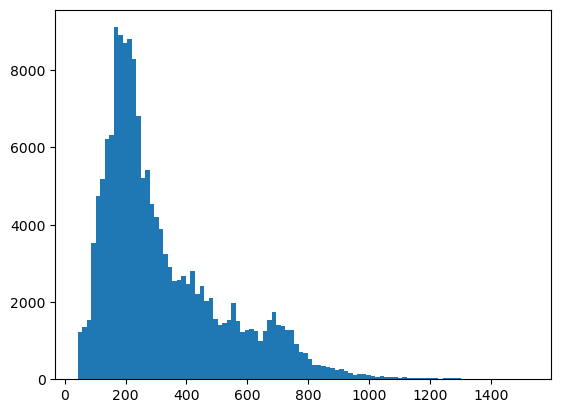

Maximum number of tokens actually needed for training examples: 1524
A total of 17 examples exceeded 1536 tokens and were split in half
A total of 0 examples exceed 1536 tokens


In [13]:
plt.hist(token_counts, bins = 100)
plt.show()
print(f"Maximum number of tokens actually needed for training examples: {max(token_counts)}")
print(f"A total of {number_split} examples exceeded {MAX_SEQ_LENGTH} tokens and were split in half")
print(f"A total of {sum([count > MAX_SEQ_LENGTH for count in token_counts])} examples exceed {MAX_SEQ_LENGTH} tokens")

In [14]:
print(f"We have {len(training_examples)} training examples, an average of {len(training_examples) / 400} per task.")

We have 164190 training examples, an average of 410.475 per task.


In [15]:
print(f"There are {len(set(training_examples))} after deduplication.")

There are 164190 after deduplication.


## Train and save

In [16]:
dataset = Dataset.from_dict({'text': training_examples})

In [18]:
trainer = SFTTrainer(
    model = codegen,
    tokenizer = codegen_tokenizer,
    train_dataset = dataset,
    args = SFTConfig(
        per_device_train_batch_size = 1,
        gradient_accumulation_steps = 8,
        dataset_text_field = "text",
        max_seq_length = MAX_SEQ_LENGTH, 
        num_train_epochs = NUM_TRAIN_EPOCHS,
        learning_rate = 2e-4,
        fp16 = True,
        bf16 = False,
        logging_steps = 1000,
        save_steps = 4000,
        optim = "adamw_torch",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
    ),
)

Map:   0%|          | 0/164190 [00:00<?, ? examples/s]

In [19]:
trainer.train()

Step,Training Loss
1000,0.256700
2000,0.171500
3000,0.146100
4000,0.137000
5000,0.129000
6000,0.129800
7000,0.124700
8000,0.121800
9000,0.118400
10000,0.114100


TrainOutput(global_step=20523, training_loss=0.12361883609457415, metrics={'train_runtime': 8445.752, 'train_samples_per_second': 19.441, 'train_steps_per_second': 2.43, 'total_flos': 9.769847476322304e+16, 'train_loss': 0.12361883609457415, 'epoch': 0.9999634569705829})